<a href="https://colab.research.google.com/github/lucarenz1997/recommender_systems/blob/main/NCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/lucarenz1997/recommender_systems/blob/main/NCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** Authors **: Rafaella and Luca
## Provisorischer Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Loading the dataset
#import pandas as pd
#data = pd.read_csv("/content/drive/MyDrive/Recommender/train.csv")


import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
sss

ModuleNotFoundError: No module named 'google'

## NCF (Neural Collaborative Filtering) Train model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate

# Mapping von user_id und media_id zu Indizes für das Modell
user_map = {u: i for i, u in enumerate(df_encoded['user_id'].unique())}
media_map = {m: i for i, m in enumerate(df_encoded['media_id'].unique())}

df_encoded['user_idx'] = df_encoded['user_id'].map(user_map)
df_encoded['media_idx'] = df_encoded['media_id'].map(media_map)

# Trainings- und Testdaten aufteilen
train, test = train_test_split(df_encoded, test_size=0.2, random_state=42)

# Embedding-Dimensionen
embedding_dim = 32

# NCF-Modell definieren
user_input = Input(shape=(1,))
media_input = Input(shape=(1,))

user_embedding = Embedding(input_dim=len(user_map), output_dim=embedding_dim)(user_input)
media_embedding = Embedding(input_dim=len(media_map), output_dim=embedding_dim)(media_input)

user_flatten = Flatten()(user_embedding)
media_flatten = Flatten()(media_embedding)

concat = Concatenate()([user_flatten, media_flatten])
dense = Dense(64, activation='relu')(concat)
dense = Dense(32, activation='relu')(dense)
output = Dense(1, activation='sigmoid')(dense)  # Vorhersage zwischen 0 und 1

# Modell kompilieren
model = Model(inputs=[user_input, media_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Trainingsdaten
X_train = [train['user_idx'].values, train['media_idx'].values]
y_train = train['is_listened'].values

# Testdaten
X_test = [test['user_idx'].values, test['media_idx'].values]
y_test = test['is_listened'].values

# Modell trainieren
model.fit(X_train, y_train, epochs=5, batch_size=512, validation_data=(X_test, y_test))


ModuleNotFoundError: No module named 'tensorflow'


This  shows how outliers were identified and removed using one of the outlier removal methods called IQR.

When analyzing ts_listen, it was shown that most of the timestamps were after 2016 while less than one thousand songs were listened before 2016. Therefore, it has been decided to remove outliers.

In [ ]:
user_song_counts.describe()

,media_id
count,19918.000000
mean,358.971332
std,480.852396
min,0.000000
25%,62.000000
50%,186.000000
75%,468.000000
max,6006.000000


In [ ]:
import pandas as pd
fraction = 0.2

# Calculate the total number of songs each user has listened to
user_song_counts = data.groupby('user_id')['media_id'].count()

# Bin these counts into categories
bins = [0, 60, 190, 500, float('inf')]  # 25th, 50th, 75th percentile
labels = ['low', 'medium', 'high', 'very high']
data['activity_level'] = pd.cut(user_song_counts, bins=bins, labels=labels, right=False)

# Join this back to the main dataset
data = data.join(data['user_id'].map(data['activity_level']), on='user_id', rsuffix='_r')

# Perform stratified sampling
sampled_data = data.groupby('activity_level', group_keys=False).apply(lambda x: x.sample(frac=fraction, random_state=42))


In [ ]:
# Calculate proportions of each activity level in the ORIGINAL data
original_proportions = data['activity_level'].value_counts(normalize=True)
print("Original Data Proportions:\n", original_proportions)

# Calculate proportions of each activity level in the SAMPLED data
sample_proportions = sampled_data['activity_level'].value_counts(normalize=True)
print("Sampled Data Proportions:\n", sample_proportions)


Original Data Proportions:
 activity_level
medium       0.265475
high         0.260036
low          0.242321
very high    0.232168
Name: proportion, dtype: float64
Sampled Data Proportions:
 activity_level
medium       0.265475
high         0.260036
low          0.242424
very high    0.232064
Name: proportion, dtype: float64


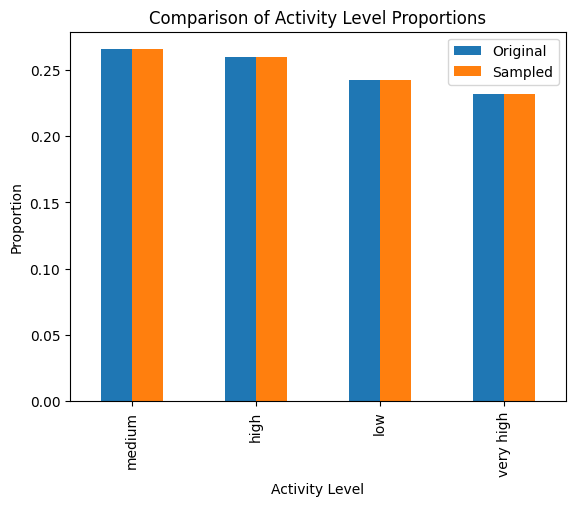

In [ ]:
import matplotlib.pyplot as plt

# Create a DataFrame to hold the proportions
comparison_df = pd.DataFrame({
    'Original': original_proportions,
    'Sampled': sample_proportions
})

comparison_df.plot(kind='bar')
plt.title('Comparison of Activity Level Proportions')
plt.ylabel('Proportion')
plt.xlabel('Activity Level')
plt.show()


# Dimension Reduction
For many features such as genre_id, artist_id, etc. there are several thousand unique values. Therefore, to not stretch our matrices unnecessarily and remove complexity, it has been decided to use minimum thresholds for specific categories which will reduce dimensions.

In [ ]:
genre_counts = sampled_data.groupby('genre_id')['genre_id'].count()

# Filter out genres that appear less than a threshold
threshold = 1
rare_genres = genre_counts[genre_counts < threshold].index

# Filter your data to only include songs with these genres
filtered_data = sampled_data[~sampled_data['genre_id'].isin(rare_genres)]

print(f"There are {len(rare_genres)} genres with fewer than {threshold} streams in the dataset.")
print(f"This corresponds to {round(len(rare_genres) * 100 / len(genre_counts), 2)}% of all streams.\n")

There are 2818 genres with fewer than 1 streams in the dataset.
This corresponds to 96.44% of all streams.



In [ ]:
genre_counts

,genre_id
genre_id,
0,4
1,4
2,3
3,41
4,0
...,...
257431,0
258111,0
258911,0


# Feature Engineering

In [ ]:
# Feature Engineering
sampled_data["genre_popularity"] = sampled_data.groupby('genre_id')['genre_id'].transform('count')
sampled_data["media_popularity"] = sampled_data.groupby('media_id')['media_id'].transform('count')
sampled_data["artist_popularity"] = sampled_data.groupby('artist_id')['artist_id'].transform('count')
sampled_data["album_popularity"] = sampled_data.groupby('album_id')['album_id'].transform('count')
sampled_data['songs_listened'] = sampled_data.groupby('user_id')['media_id'].transform('count')

user_top_genre = sampled_data.groupby(['user_id', 'genre_id']).size().groupby(level=0).idxmax().apply(lambda x: x[1])
sampled_data['user_top_genre'] = sampled_data['user_id'].map(user_top_genre)

# Not possible due to limited resources
# user_top_artist = sampled_data.groupby(['user_id', 'artist_id']).size().groupby(level=0).idxmax().apply(lambda x: x[1])
# sampled_data['user_top_artist'] = sampled_data['user_id'].map(user_top_artist)

# user_top_song = sampled_data.groupby(['user_id', 'media_id']).size().groupby(level=0).idxmax().apply(lambda x: x[1])
# sampled_data['user_top_song'] = sampled_data['user_id'].map(user_top_song)



In [ ]:
sampled_data

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,...,user_age,is_listened,activity_level,user_id_r,genre_popularity,media_popularity,artist_popularity,album_popularity,songs_listened,user_top_genre
17685,6129,2016-11-23 11:03:38,76565888,7594557,17,2014-05-19,2,1,197,0,...,28,True,low,very high,10,1,10,10,6,6129
14353,2525,2016-11-05 10:48:13,59506771,5814071,1,2012-09-24,0,2,163,1,...,28,True,low,very high,127,113,126,126,1,2525
18916,27,2016-12-01 09:52:36,86453925,8722185,1,2014-10-05,0,0,227,1,...,30,True,low,very high,517,268,268,268,1,27
19622,2744,2016-11-03 15:54:20,88552805,8947947,1,2014-11-03,0,0,189,1,...,21,False,low,very high,281,8,8,8,1,2744
18716,27,2016-11-29 21:00:23,86453925,8722185,1,2014-10-05,2,1,227,1,...,26,False,low,medium,517,268,268,268,2,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,2744,2016-11-03 18:16:33,876497,99692,0,1985-12-31,1,0,307,0,...,27,True,very high,very high,281,86,272,272,1,2744
2318,7,2016-11-07 19:44:11,1121220,120574,1,2007-10-29,0,0,174,1,...,28,False,very high,high,659,3,15,15,3,7
3074,7,2016-11-20 00:24:53,2438251,240153,2,2002-12-31,1,2,197,0,...,29,True,very high,very high,659,9,20,234,7,7
4017,7,2016-11-08 10:11:54,2476197,243305,0,2008-11-03,2,1,166,0,...,28,False,very high,very high,659,1,21,21,8,7
